# This code uses periodicity from a recording as a song detector.

### It saves a .json file with all of the file names, file paths, and the time segments of detected songs. Next, it saves .npz files for each .wav file containing its hyperparameters, log amplitude traces, amplitude trace of oscillations, the power of the filtered spectrogram, and the smoothed power.

In [3]:
import numpy as np
import os
import json
from pathlib import Path
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm


def detect_song_from_amplitude(file_path, output_npz_folder,
                                segment_duration=10,
                                audio_low_cut=500, audio_high_cut=8000,
                                modulation_low_cut=10, modulation_high_cut=40,
                                smoothing_sigma=3, power_threshold=0.5,
                                save_spectrograms=False):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        nyquist = samplerate / 2
        wp = [audio_low_cut / nyquist, audio_high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(len(data) / segment_length_samples))

        detected_segments = []
        all_log_amplitude_trace = []
        all_oscillatory_power = []
        all_smoothed_power = []

        last_Sxx = last_f = last_t = None
        last_Sxx_amp = last_f_amp = last_t_amp = None

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = min(start_sample + segment_length_samples, len(data))
            segment_data = data[start_sample:end_sample]

            if len(segment_data) < segment_length_samples:
                padded = np.zeros(segment_length_samples, dtype=segment_data.dtype)
                padded[:len(segment_data)] = segment_data
                segment_data = padded

            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119
            )

            freq_mask = (f >= audio_low_cut) & (f <= audio_high_cut)
            amplitude_trace = np.sum(Sxx[freq_mask, :], axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            amp_fs = len(t) / segment_duration
            nperseg = 128
            pad_len = nperseg // 2
            expected_length = int(segment_duration * amp_fs)

            pad_start = pad_len
            pad_end = expected_length + pad_len - len(log_amplitude_trace)
            pad_end = max(pad_end, 0)
            padded_trace = np.pad(log_amplitude_trace, (pad_start, pad_end), mode='constant')

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded_trace,
                fs=amp_fs,
                window='hann',
                nperseg=nperseg,
                noverlap=96
            )
            t_amp = t_amp_raw - (nperseg / 2) / amp_fs

            band_mask = (f_amp >= modulation_low_cut) & (f_amp <= modulation_high_cut)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)

            all_log_amplitude_trace.extend(log_amplitude_trace)
            all_oscillatory_power.extend(band_power)
            all_smoothed_power.extend(smoothed_power)

            above_thresh = smoothed_power > power_threshold
            in_segment = False
            segment_start = 0

            for j, is_above in enumerate(above_thresh):
                current_time = t_amp[j] + i * segment_duration
                if is_above and not in_segment:
                    in_segment = True
                    segment_start = current_time
                elif not is_above and in_segment:
                    segment_end = current_time
                    detected_segments.append([float(segment_start), float(segment_end)])
                    in_segment = False

            if in_segment:
                segment_end = t_amp[-1] + i * segment_duration
                detected_segments.append([float(segment_start), float(segment_end)])

            # Save last spectrograms (only one example per file)
            last_Sxx, last_f, last_t = Sxx, f, t
            last_Sxx_amp, last_f_amp, last_t_amp = Sxx_amp, f_amp, t_amp

        save_dict = dict(
            log_amplitude_trace=np.array(all_log_amplitude_trace),
            oscillatory_power=np.array(all_oscillatory_power),
            smoothed_power=np.array(all_smoothed_power),
            audio_bandpass_low_cut=audio_low_cut,
            audio_bandpass_high_cut=audio_high_cut,
            modulation_bandpass_low_cut=modulation_low_cut,
            modulation_bandpass_high_cut=modulation_high_cut,
            Gaussian_smoothing_sigma=smoothing_sigma,
            amplitude_power_threshold=power_threshold,
            segment_duration=segment_duration
        )

        if save_spectrograms:
            save_dict.update(
                audio_spectrogram=last_Sxx,
                audio_frequencies=last_f,
                audio_times=last_t,
                modulation_spectrogram=last_Sxx_amp,
                modulation_frequencies=last_f_amp,
                modulation_times=last_t_amp
            )

        base_name = Path(file_path).stem
        npz_path = os.path.join(output_npz_folder, f"{base_name}_amplitude_modulation_traces.npz")
        np.savez(npz_path, **save_dict)

        return {
            "file_name": Path(file_path).name,
            "file_path": str(Path(file_path).resolve()),
            "detected_segments": detected_segments
        }

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None


def process_folder_with_detailed_outputs(folder_path,
                                         segment_duration=10,
                                         audio_low_cut=500, audio_high_cut=8000,
                                         modulation_low_cut=10, modulation_high_cut=40,
                                         smoothing_sigma=3, power_threshold=0.5,
                                         save_spectrograms=False):

    folder_path = Path(folder_path)
    parent_dir = folder_path.parent
    folder_name = folder_path.name
    output_folder = parent_dir / f"{folder_name}_amplitude_modulation_detection_outputs"
    npz_folder = output_folder / "npz_traces"
    os.makedirs(npz_folder, exist_ok=True)

    metadata = []
    wav_files = sorted([f for f in folder_path.iterdir() if f.suffix.lower() == '.wav'])

    for file_path in tqdm(wav_files, desc="Processing .wav files", unit="file"):
        info = detect_song_from_amplitude(
            file_path,
            output_npz_folder=npz_folder,
            segment_duration=segment_duration,
            audio_low_cut=audio_low_cut,
            audio_high_cut=audio_high_cut,
            modulation_low_cut=modulation_low_cut,
            modulation_high_cut=modulation_high_cut,
            smoothing_sigma=smoothing_sigma,
            power_threshold=power_threshold,
            save_spectrograms=save_spectrograms
        )
        if info:
            metadata.append(info)

    json_path = output_folder / "detected_song_segments.json"
    with open(json_path, "w") as f:
        json.dump(metadata, f, indent=4)

    print(f"\n✅ Saved JSON metadata: {json_path}")
    print(f"✅ Saved .npz traces in: {npz_folder}/")


In [4]:
# === USER SETUP ===
folder_path = '//Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55'

process_folder_with_detailed_outputs(
    folder_path,
    segment_duration=10,
    audio_low_cut=500,
    audio_high_cut=8000,
    modulation_low_cut=10,
    modulation_high_cut=40,
    smoothing_sigma=5,
    power_threshold=0.13,
    save_spectrograms=True  # 👈 Toggle this ON/OFF
)

Processing .wav files: 100%|██████████| 200/200 [01:28<00:00,  2.25file/s]


✅ Saved JSON metadata: //Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_amplitude_modulation_detection_outputs/detected_song_segments.json
✅ Saved .npz traces in: //Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_amplitude_modulation_detection_outputs/npz_traces/


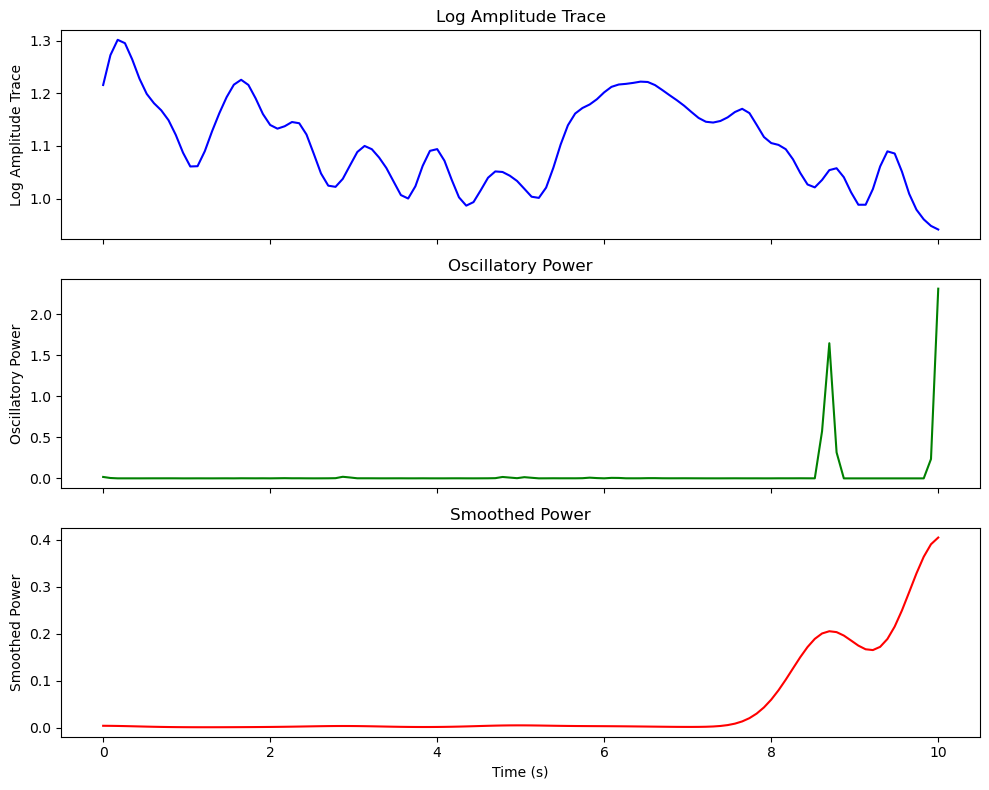

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_npz_data(npz_filename):
#     try:
#         # Load the .npz file
#         npz_data = np.load(npz_filename)

#         # Extract data from the .npz file
#         log_amplitude_trace = npz_data['log_amplitude_trace']
#         oscillatory_power = npz_data['oscillatory_power']
#         smoothed_power = npz_data['smoothed_power']

#         # Time for the log_amplitude_trace assuming it spans the whole segment duration
#         segment_duration = npz_data['segment_duration']
#         time_log_amplitude = np.linspace(0, segment_duration * len(log_amplitude_trace) / len(oscillatory_power), len(log_amplitude_trace))

#         # Time for oscillatory_power and smoothed_power
#         time_power = np.linspace(0, segment_duration, len(oscillatory_power))

#         # Interpolation to align log_amplitude_trace with the time for oscillatory_power
#         log_amplitude_trace_resampled = np.interp(time_power, time_log_amplitude, log_amplitude_trace)

#         # Create the figure and axes
#         fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

#         # Plot Log Amplitude Trace
#         axes[0].plot(time_power, log_amplitude_trace_resampled, color='blue')
#         axes[0].set_ylabel('Log Amplitude Trace')
#         axes[0].set_title('Log Amplitude Trace')

#         # Plot Oscillatory Power
#         axes[1].plot(time_power, oscillatory_power, color='green')
#         axes[1].set_ylabel('Oscillatory Power')
#         axes[1].set_title('Oscillatory Power')

#         # Plot Smoothed Power
#         axes[2].plot(time_power, smoothed_power, color='red')
#         axes[2].set_ylabel('Smoothed Power')
#         axes[2].set_title('Smoothed Power')
#         axes[2].set_xlabel('Time (s)')

#         plt.tight_layout()
#         plt.show()

#     except Exception as e:
#         print(f"❌ Error processing {npz_filename}: {e}")

# # Example usage:
# npz_filename = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_amplitude_modulation_detection_outputs/npz_traces/USA5510_45755.22382904_4_8_6_13_2_amplitude_modulation_traces.npz'
# plot_npz_data(npz_filename)
